In [1]:
!pip install -q -U watermark

In [2]:
!pip install -qq transformers


In [3]:

#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
df_ans= pd.read_csv('ansr_final.csv',  header=0, low_memory=False)
df_tti= pd.read_csv('ttislm_final.csv', header=0, low_memory=False)
df_mov= pd.read_csv('mov_final.csv',  header=0, low_memory=False)
df_s140= pd.read_csv('sent140_final.csv',  header=0, low_memory=False)
df_t4sa= pd.read_csv('t4sa_final.csv', header=0, low_memory=False)

In [5]:
#df_t4sa['message'] = df_t4sa['message'].astype(str)
#df_tti['message'] = df_tti['message'].astype(str)
#df_mov['message'] = df_mov['message'].astype(str)
#df_s140['message'] = df_s140['message'].astype(str)
#df_ans['message'] = df_ans['message'].astype(str)

In [6]:
#df_t4sa.dtypes , df_tti.dtypes, df_ans.dtypes , df_s140.dtypes, df_t4sa.dtypes

In [6]:
df_t4sa = df_t4sa.drop(["polarity"], axis=1)


In [7]:
df_tti = df_tti.drop(["index"], axis=1)

In [8]:
df_mov= df_mov.drop(["polarity"], axis=1)

In [9]:
df_s140 = df_s140.drop(["polarity"], axis=1)

In [10]:
df_t4sa

,message,label
0,got me like https//t.co/s8hRO62rId,0
1,Want to look incredible? Wear the impossible P...,0
2,TITANBET-Get a £50 FREE bet bonus + MONEY back...,0
3,How to time your tweets for maximum impact htt...,0
4,"Come join me, or you'll be left behind #BIGOLI...",0
...,...,...
72337,you have no idea how badly i want to sleep(wip...,2
72338,Big Studios Consider the Unthinkable Home View...,2
72339,Happy 17th birthday the the dime piece that ke...,2
72340,my auntie got a naughty elf for my little cou...,2


In [11]:
df_all = pd.concat([df_s140,df_mov,df_tti,df_t4sa,df_ans],ignore_index=True)

In [12]:
df_all

,message,label
0,Pissed at Time Warner for causin me to have sl...,0
1,jquery Selectors http//codylindley.com/jquerys...,0
2,Watching Night at the Museum - giggling.,0
3,SOOO DISSAPOiNTED THEY SENT DANNY GOKEY HOME.....,0
4,"I'm ready to drop the pretenses, I am forever ...",0
...,...,...
90571,Quote: Originally Posted by FIGHTER Losing gro...,2
90572,Aswat Al-Iraq reports that 3 crusaders were ki...,2
90573,Hackers infiltrate costliest US weapons projec...,2
90574,From the telegraph site Quote: 'Friendly-fire'...,2


In [13]:
df_all= df_all.sample(frac=1).reset_index(drop=True)

In [14]:
df_all['message_len'] = df_all['message'].apply(lambda x: len(str(x).split()))
df_all["message_len"].describe().apply(lambda x: format(x, 'f'))

count    90576.000000
mean        69.151420
std        257.615244
min          1.000000
25%          9.000000
50%         13.000000
75%         18.000000
max       2300.000000
Name: message_len, dtype: object

In [18]:
df_all= df_all.drop(["message_len"], axis=1)

In [19]:
df_all

,message,label
0,look at how perfect his teeth are King of Oral...,1
1,conversation was over like shit https//t.co/r...,2
2,i luved these pictures..i luv nature pics..tha...,1
3,#youreeeeaaaady 😂😂😂🔥🔥🔥🍳🍳🍳 Shit was lowkey ...,2
4,it's ugly sweater season 😌😏🎅🏼 https//t.co/V5TV...,1
...,...,...
90571,laughingnext............,1
90572,Please #interiordesign #decoration #architec...,1
90573,WE THINK TRUMP WILL BE NEGATIVE IN OUR TRADES ...,2
90574,a welcome relief from baseball movies that try...,1


In [20]:
df_train, df_test = train_test_split(
  df_all,
  test_size=0.2,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [21]:
df_train.shape, df_val.shape, df_test.shape

((72460, 2), (9058, 2), (9058, 2))

In [22]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

In [23]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
MAX_LEN = 232

In [25]:
class ExtremsSentiDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):

    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
      
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [26]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ExtremsSentiDataset(
    reviews=df.message.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
  )

In [27]:
BATCH_SIZE = 9

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [28]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [29]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [31]:
class_names = ['Inconclusive', 'Positive Extreme', 'Negative Extreme']

In [32]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([9, 232])
torch.Size([9, 232])


In [34]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5357, 0.1703, 0.2940],
        [0.5219, 0.1726, 0.3054],
        [0.4695, 0.2089, 0.3216],
        [0.4213, 0.0957, 0.4830],
        [0.4693, 0.1143, 0.4165],
        [0.4155, 0.2059, 0.3786],
        [0.6371, 0.1644, 0.1985],
        [0.3063, 0.1285, 0.5652],
        [0.5361, 0.1275, 0.3364]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [35]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [36]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:


import torch

# Check GPU memory using nvidia-smi
#del train_data_loader
#del val_data_loader
#del test_data_loader
torch.cuda.empty_cache()
# Check GPU memory again

In [36]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [39]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 6)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/6
------
Train loss 0.40033908597521506 accuracy 0.8602125310516147
Val   loss 0.2623796365777578 accuracy 0.9315522190328991

Epoch 2/6
------
Train loss 0.20624961882653683 accuracy 0.9443693072039746
Val   loss 0.18279990364354412 accuracy 0.9472289688672996

Epoch 3/6
------
Train loss 0.15370457907867854 accuracy 0.9615512006624345
Val   loss 0.1910146566214169 accuracy 0.9555089423713844

Epoch 4/6
------
Train loss 0.11637626307086885 accuracy 0.9726469776428374
Val   loss 0.2192554371556469 accuracy 0.9545153455508942

Epoch 5/6
------
Train loss 0.08298893563285673 accuracy 0.9813828319072592
Val   loss 0.27046310800506757 accuracy 0.9508721572090969

Epoch 6/6
------
Train loss 0.05810228740947048 accuracy 0.9871929340325697
Val   loss 0.2709719053532647 accuracy 0.9547361448443364

CPU times: user 5h 4min 15s, sys: 29.7 s, total: 5h 4min 45s
Wall time: 5h 5min 7s


Epoch 1/6
------
Train loss 0.2818932763231003 accuracy 0.9253733470132239
Val   loss 0.1757286980812834 accuracy 0.9668262653898768

Epoch 2/6
------

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

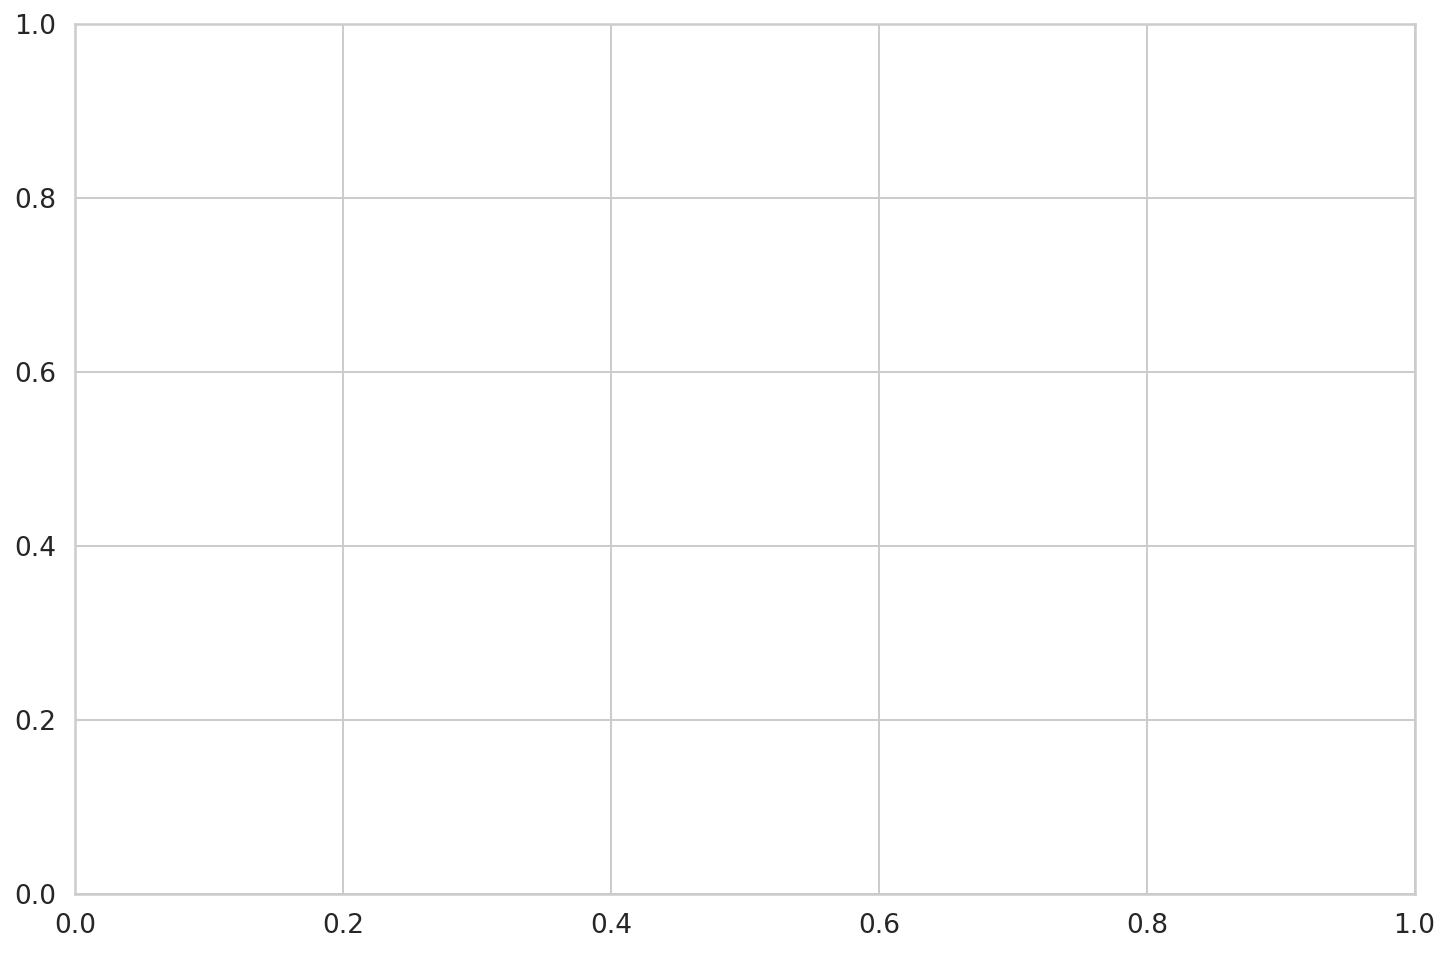

In [54]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [45]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


0.9530801501435195

In [70]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

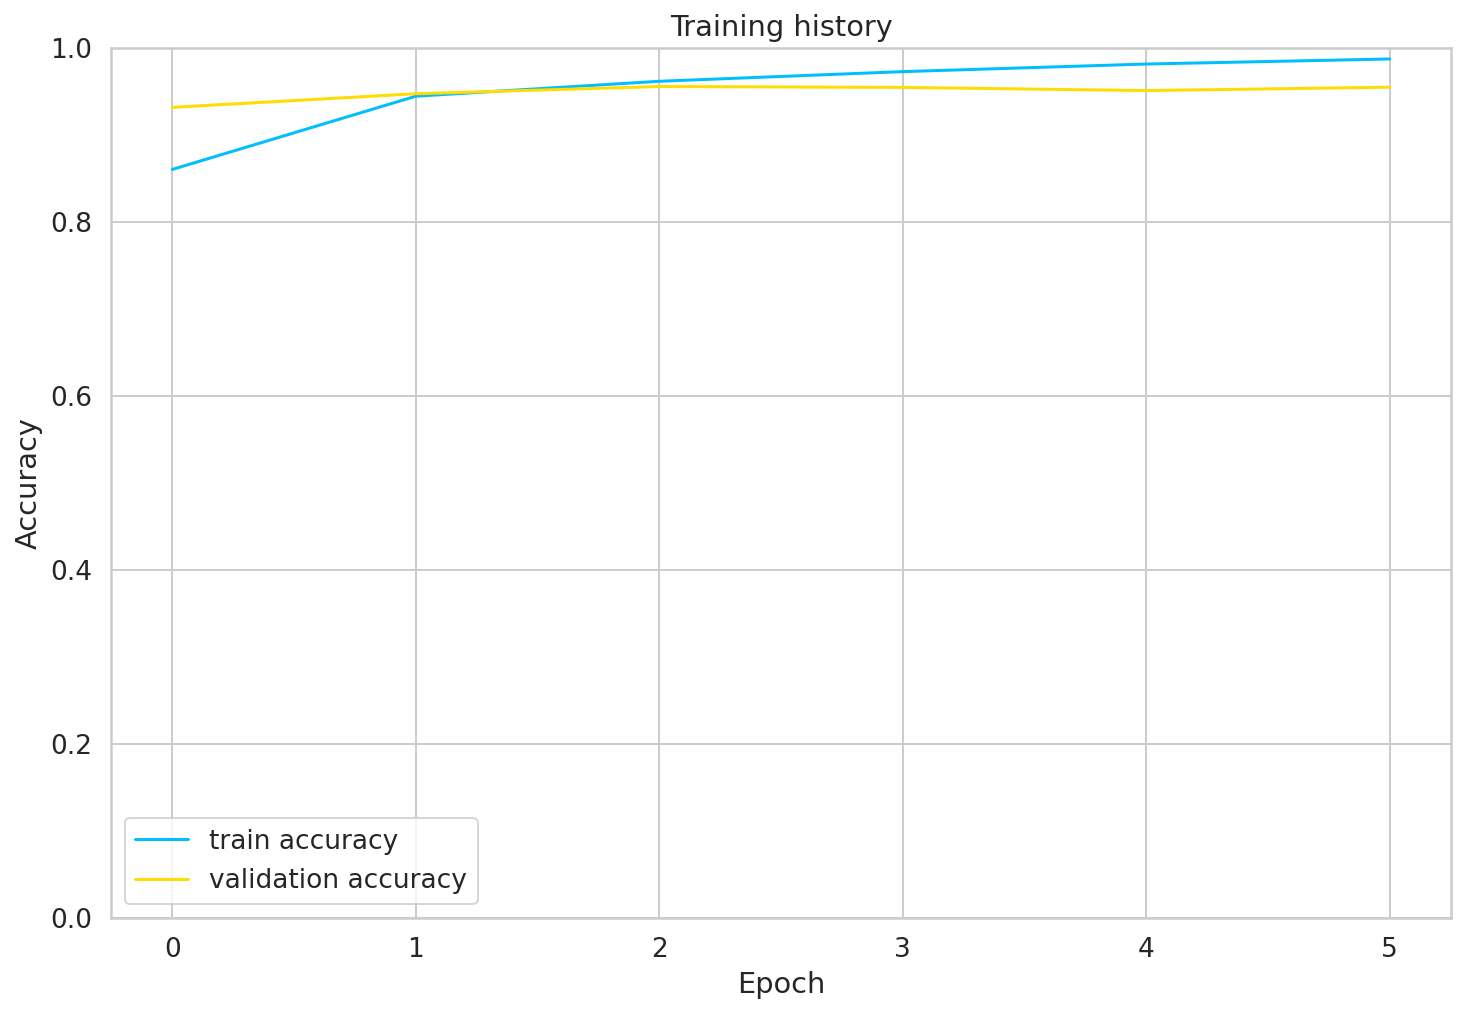

In [69]:
plt.plot(tr_acc, label='train accuracy')
plt.plot(va_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [56]:
a = history['train_acc'].cpu().numpy()
b = history['val_acc'].cpu().numpy()

AttributeError: 'list' object has no attribute 'cpu'

In [60]:
history['train_acc']

[tensor(0.8602, device='cuda:0', dtype=torch.float64),
 tensor(0.9444, device='cuda:0', dtype=torch.float64),
 tensor(0.9616, device='cuda:0', dtype=torch.float64),
 tensor(0.9726, device='cuda:0', dtype=torch.float64),
 tensor(0.9814, device='cuda:0', dtype=torch.float64),
 tensor(0.9872, device='cuda:0', dtype=torch.float64)]

In [66]:
history['val_acc']

[tensor(0.9316, device='cuda:0', dtype=torch.float64),
 tensor(0.9472, device='cuda:0', dtype=torch.float64),
 tensor(0.9555, device='cuda:0', dtype=torch.float64),
 tensor(0.9545, device='cuda:0', dtype=torch.float64),
 tensor(0.9509, device='cuda:0', dtype=torch.float64),
 tensor(0.9547, device='cuda:0', dtype=torch.float64)]

In [67]:
tr_acc = torch.tensor(a, device = 'cpu')

In [68]:
va_acc=  torch.tensor(b, device = 'cpu')

In [65]:
a = a.to('cpu').numpy()

AttributeError: 'list' object has no attribute 'to'

In [59]:
model(SentimentClassifier(0).cuda()).deatch().cpu()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TypeError: forward() missing 1 required positional argument: 'attention_mask'

In [ ]:
SentimentClassifier(len(class_names))